<a href="https://colab.research.google.com/github/Morioh/swahili-translation/blob/main/English_Swahili_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English-Swahili Translation

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

## Data Preprocessing

In [2]:
# Sample data (English to Swahili)
data = [
    ("I am", "mimi ni"),
    ("Are you sure?", "Je, una uhakika?"),
    ("I have a headache.", "Kichwa kinauma."),
    ("I don't want to go to school.", "Sitaki kwenda shule."),
    ("Can you keep a secret?", "Je, unaweza kutunza siri?"),
    ("If he had stayed at home that day, he would not have met with disaster.", "Kama angekaa nyumbani, asingepata taabu."),
    ("Would you like another cup of coffee?", "Je, ungependa kikombe kingine cha kahawa?"),
    ("I come from England.", "Wote tuliangalia saa yake."),
    ("I come from Saitama.", "Ninatoka Saitama."),
    ("It would have been better if you had not gone there.", "Bora usingekwenda hapo."),
    ("He is responsible for it.", "Ni kazi yake."),
    ("Fine. I'd be very happy if you would drop me a line as soon as you get to Mwanza.", "Vema. Ningefurahi sana kama ungeniandikia barua mara tu ufikapo Mwanza."),
    ("He does not have any friends.", "Yeye hana rafiki ye yote."),
    ("Magdalena and Ania are good friends.", "Magdalena na Ania ni marafiki wazuri")
]

# Split data into English and Swahili
english_sentences = [pair[0] for pair in data]
swahili_sentences = [pair[1] for pair in data]

# Add special tokens to Swahili sentences (start and end tokens)
swahili_sentences = ["start_token " + sentence + " end_token" for sentence in swahili_sentences]

# Tokenizer for English
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(english_sentences)
english_sequences = english_tokenizer.texts_to_sequences(english_sentences)

# Tokenizer for Swahili
swahili_tokenizer = Tokenizer()
swahili_tokenizer.fit_on_texts(swahili_sentences)
swahili_sequences = swahili_tokenizer.texts_to_sequences(swahili_sentences)

# Pad sequences to ensure equal length
max_encoder_seq_length = max([len(seq) for seq in english_sequences])
max_decoder_seq_length = max([len(seq) for seq in swahili_sequences])

english_sequences_padded = pad_sequences(english_sequences, maxlen=max_encoder_seq_length, padding='post')
swahili_sequences_padded = pad_sequences(swahili_sequences, maxlen=max_decoder_seq_length, padding='post')

# Vocabulary sizes (accounting for start_token and end_token)
english_vocab_size = len(english_tokenizer.word_index) + 1
swahili_vocab_size = len(swahili_tokenizer.word_index) + 1

# Prepare target data for training (shift decoder output by one time step)
decoder_input_data = swahili_sequences_padded[:, :-1]
decoder_target_data = swahili_sequences_padded[:, 1:]

# Convert target data to one-hot encoding
decoder_target_data = tf.keras.utils.to_categorical(decoder_target_data, swahili_vocab_size)

# Output the shapes of the processed data to verify correctness
print(f"English sequences padded shape: {english_sequences_padded.shape}")
print(f"Swahili sequences padded shape: {swahili_sequences_padded.shape}")
print(f"Decoder input data shape: {decoder_input_data.shape}")
print(f"Decoder target data shape: {decoder_target_data.shape}")
print(f"English vocab size: {english_vocab_size}")
print(f"Swahili vocab size: {swahili_vocab_size}")

English sequences padded shape: (14, 19)
Swahili sequences padded shape: (14, 14)
Decoder input data shape: (14, 13)
Decoder target data shape: (14, 13, 56)
English vocab size: 66
Swahili vocab size: 56


## Model Development

In [3]:
# Model parameters
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(english_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(swahili_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(swahili_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn encoder_input_data & decoder_input_data into decoder_target_data
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │         16,896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │         14,336 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 512), (None,   │      1,574,912 │ embedding[0][0]        │
│                           │ 512), (None, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 512),    │      1,574,912 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 56)       │         28,728 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,209,784 (12.24 MB)

 Trainable params: 3,209,784 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [4]:
# Training data
encoder_input_data = english_sequences_padded
decoder_input_data = swahili_sequences_padded[:, :-1]

# Train the model
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=64, epochs=100, validation_split=0.2)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - loss: 4.0270 - val_accuracy: 0.3077 - val_loss: 3.9419
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5874 - loss: 3.8157 - val_accuracy: 0.3077 - val_loss: 3.7479
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - accuracy: 0.5874 - loss: 3.3238 - val_accuracy: 0.2308 - val_loss: 3.6974
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.5105 - loss: 2.2052 - val_accuracy: 0.3077 - val_loss: 3.6133
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step - accuracy: 0.6364 - loss: 3.0067 - val_accuracy: 0.3077 - val_loss: 3.1142
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.5874 - loss: 1.9877 - val_accuracy: 0.3077 - val_loss: 3.5803
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5874 - loss: 1.7948 - val_accuracy: 0.3333 - val_loss: 3.0430
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step - accuracy: 0.5944 - loss: 1.8881 - val_accuracy: 0.3077 - 

In [5]:
model.evaluate([encoder_input_data, decoder_input_data], decoder_target_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7527 - loss: 1.3987


[1.398736596107483, 0.7527472376823425]

## Evaluation

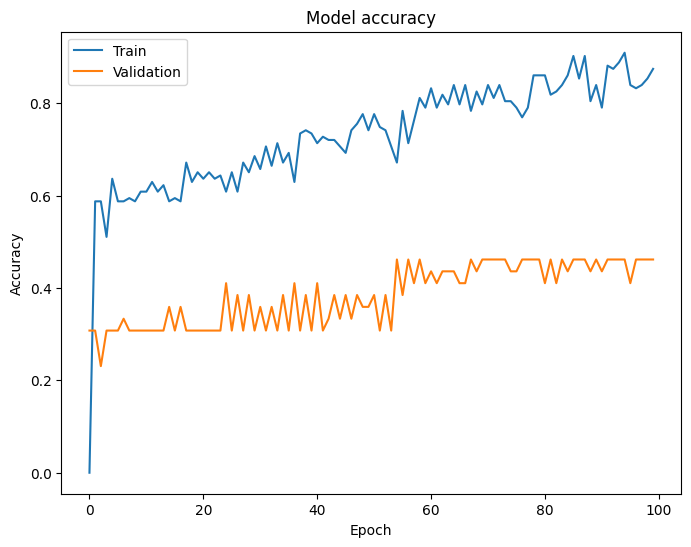

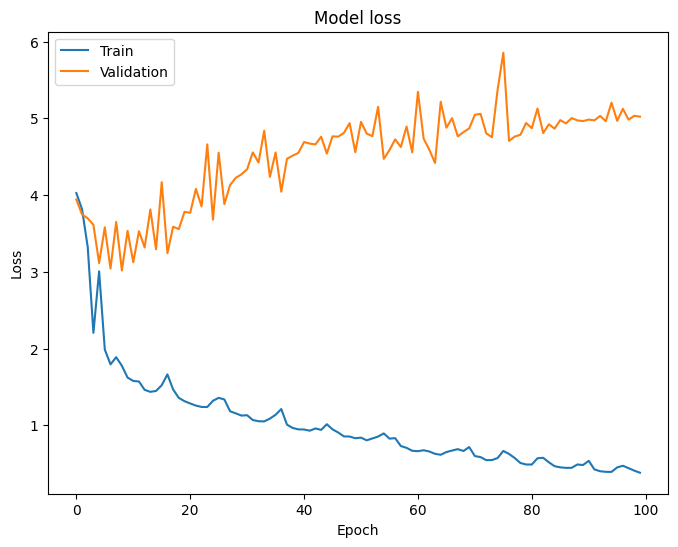

In [6]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [7]:
# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

def translate_sentence(input_sentence):
    input_seq = english_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_encoder_seq_length, padding='post')

    # Encode input
    states_value = encoder_model.predict(input_seq)

    # Generate translation
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = swahili_tokenizer.word_index['start']  # Start token

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = swahili_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == 'end' or len(decoded_sentence.split()) > max_decoder_seq_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update target sequence (for the next time step) and states
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

In [8]:
print(swahili_tokenizer.word_index)  # This should now contain 'start_token' and 'end_token'

{'token': 1, 'start': 2, 'end': 3, 'ni': 4, 'je': 5, 'kama': 6, 'yake': 7, 'mimi': 8, 'una': 9, 'uhakika': 10, 'kichwa': 11, 'kinauma': 12, 'sitaki': 13, 'kwenda': 14, 'shule': 15, 'unaweza': 16, 'kutunza': 17, 'siri': 18, 'angekaa': 19, 'nyumbani': 20, 'asingepata': 21, 'taabu': 22, 'ungependa': 23, 'kikombe': 24, 'kingine': 25, 'cha': 26, 'kahawa': 27, 'wote': 28, 'tuliangalia': 29, 'saa': 30, 'ninatoka': 31, 'saitama': 32, 'bora': 33, 'usingekwenda': 34, 'hapo': 35, 'kazi': 36, 'vema': 37, 'ningefurahi': 38, 'sana': 39, 'ungeniandikia': 40, 'barua': 41, 'mara': 42, 'tu': 43, 'ufikapo': 44, 'mwanza': 45, 'yeye': 46, 'hana': 47, 'rafiki': 48, 'ye': 49, 'yote': 50, 'magdalena': 51, 'na': 52, 'ania': 53, 'marafiki': 54, 'wazuri': 55}


## Reporting

In [9]:
# Reference and candidate translations
reference = ['mimi ni'.split()]
candidate = translate_sentence('I am').split()

# Compute BLEU score
from nltk.translate.bleu_score import sentence_bleu
bleu_score = sentence_bleu(reference, candidate)
print(f"BLEU Score: {bleu_score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
BLEU Score: 0


In [11]:
# Define some test sentences for translation
test_sentences = [
    "Can you keep a secret?",
    "It would have been better if you had not gone there.",
    "He does not have any friends.",
    "I come from Saitama.",
    "Magdalena and Ania are good friends."
]

# Define the reference translations in Swahili
reference_translations = [
    "Je, unaweza kutunza siri?",
    "Bora usingekwenda hapo.",
    "Yeye hana rafiki ye yote.",
    "Ninatoka Saitama.",
    "Magdalena na Ania ni marafiki wazuri"
]

# Loop through the test cases and calculate BLEU scores
for i, sentence in enumerate(test_sentences):
    predicted_translation = translate_sentence(sentence)
    reference = [reference_translations[i].split()]
    candidate = predicted_translation.split()
    bleu_score = sentence_bleu(reference, candidate)
    print(f"English Sentence: {sentence}")
    print(f"Predicted Translation: {predicted_translation}")
    print(f"Reference Translation: {' '.join(reference[0])}")
    print(f"BLEU Score: {bleu_score}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
English Sentence: Can you keep a secret?
Predicted Translation: token je una
Reference Translation: Je, unaweza kutunza siri?
BLEU Score: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
English Sentence: It would have been better if you had not gone there.
Predicted Translation: token bora kwenda shule
Reference Translation: Bora usingekwenda hapo.
BLEU Score: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
English Sentence: He does not hav

## Observations on Translation Model Performance

### Key Observations
1. **Low BLEU Scores**:
  
2. **Repetitive Output**:
  
3. **Failure to Adapt**:
   
4. **Warnings in BLEU Calculation**:
   
---

### Potential Causes
- **Data Issues**:
  - Insufficient or poor-quality training data.
- **Model Undertraining**:
  - The model may not have been trained for enough epochs or lacked exposure to relevant data.